In [12]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, issparse
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from anndata import AnnData
import scanpy as sc
import os
import igraph
import leidenalg
import matplotlib.pyplot as plt
# Steps 1-5 not great in python

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt


# Cell 1


AttributeError: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.

In [ ]:
# Cell 2 (modified)
print("Loading data")

# Load raw data
counts_1 = pd.read_csv("../WTA1/WTA-Pipeline-Brain-slices_RSEC_MolsPerCell.csv", 
                       skiprows=7, sep=",", index_col=0)
counts_2 = pd.read_csv("../WTA2/_1_WTA-Pipeline-Brain-slices_RSEC_MolsPerCell.csv", 
                       skiprows=7, sep=",", index_col=0)
counts_3 = pd.read_csv("../WTA3/_3_WTA-Pipeline-Brain-slices_RSEC_MolsPerCell.csv", 
                       skiprows=7, sep=",", index_col=0)
counts_4 = pd.read_csv("../WTA4/_2_WTA-Pipeline-Brain-slices_RSEC_MolsPerCell.csv", 
                       skiprows=7, sep=",", index_col=0)

# Print the first 5 rows and first 5 columns of counts_1 to verify
print("Preview of counts_1 (first 5 rows and columns):")
print(counts_1.iloc[:5, :5])

# Print the row index and column names to verify
print("Row index (first 10):", counts_1.index[:10])
print("Column names (first 10):", counts_1.columns[:10])

# Transpose so cells are rows and genes are columns
counts_1 = counts_1.T
counts_2 = counts_2.T
counts_3 = counts_3.T
counts_4 = counts_4.T

# Confirm the shapes of transposed data
print("After transpose:")
print("counts_1 shape:", counts_1.shape)
print("counts_2 shape:", counts_2.shape)
print("counts_3 shape:", counts_3.shape)
print("counts_4 shape:", counts_4.shape)


Loading data
Preview of counts_1 (first 5 rows and columns):
            0610005C13Rik  0610006L08Rik  0610009B22Rik  0610010F05Rik  \
Cell_Index                                                               
9010655                 0              0              7             19   
7253435                 0              0             16             10   
1964                    0              0              9             20   
9296317                 0              0             13             36   
1339426                 0              0              4             10   

            0610010K14Rik  
Cell_Index                 
9010655                 0  
7253435                 0  
1964                    0  
9296317                 0  
1339426                 0  
Row index (first 10): Index([ 9010655,  7253435,     1964,  9296317,  1339426, 12402497,  7248816,
        9596620,  7821406,  6518478],
      dtype='int64', name='Cell_Index')
Column names (first 10): Index(['0610005C13Rik'

In [ ]:
# Cell 3 (fixed)
print("Checking for mitochondrial genes in row labels")

# Ensure all row names are strings
counts_1.index = counts_1.index.astype(str)

# Define a list of known mitochondrial gene prefixes or IDs
mitochondrial_prefixes = ["mt-", "MT-", "Mt-"]

# Check for mitochondrial genes
mitochondrial_genes = counts_1.index[counts_1.index.str.startswith(tuple(mitochondrial_prefixes))]

# Print the mitochondrial genes found
print(f"Number of mitochondrial genes detected: {len(mitochondrial_genes)}")
print("Mitochondrial genes detected (if any):", mitochondrial_genes.tolist())

# Print the first five rows that are not mitochondrial
non_mitochondrial_genes = counts_1.index[~counts_1.index.str.startswith(tuple(mitochondrial_prefixes))]
print("First 5 non-mitochondrial genes:", non_mitochondrial_genes[:5].tolist())


Checking for mitochondrial genes in row labels
Number of mitochondrial genes detected: 13
Mitochondrial genes detected (if any): ['mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']
First 5 non-mitochondrial genes: ['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610010F05Rik', '0610010K14Rik']


In [ ]:
# Cell 4
print("Creating AnnData objects")

adatas = []
sample_names = ["WTA1", "WTA2", "WTA3", "WTA4"]




# Convert each counts DataFrame to a sparse matrix, then to AnnData
for df, sample_id in zip([counts_1, counts_2, counts_3, counts_4], sample_names):
    X_sparse = csr_matrix(df.values).T  # Sparse matrix of the transposed data, but for some reaon I need to transpose it back, honestly this stumped me for a while.
    print("First 5 genes (rows):", df.index[:5])
    print("First 5 cells (columns):", df.columns[:5])
    adata = AnnData(
        X=X_sparse,
        obs=pd.DataFrame(index=df.columns),  # Cells (rows after transpose)
        var=pd.DataFrame(index=df.index)  # Genes (columns after transpose)
    )
    adata.var_names = adata.var.index  # Explicitly set gene IDs as var_names
    adata.obs["Sample"] = sample_id    # Add sample metadata
    adatas.append(adata)

print("Finished creating individual AnnData objects")

adata_merged = sc.concat(adatas, join="outer", label="Sample", keys=sample_names)



Creating AnnData objects
First 5 genes (rows): Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610010F05Rik',
       '0610010K14Rik'],
      dtype='object')
First 5 cells (columns): Index([9010655, 7253435, 1964, 9296317, 1339426], dtype='int64', name='Cell_Index')


/Users/conorisco/Library/CloudStorage/OneDrive-TrinityCollegeDublin/TCD Omics/Runs/RCSI/data and analysis/Python_pipeline/Leo_Phelan_Project/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


First 5 genes (rows): Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610010F05Rik',
       '0610010K14Rik'],
      dtype='object')
First 5 cells (columns): Index([1198119, 1211996, 9733664, 7534081, 5621771], dtype='int64', name='Cell_Index')


/Users/conorisco/Library/CloudStorage/OneDrive-TrinityCollegeDublin/TCD Omics/Runs/RCSI/data and analysis/Python_pipeline/Leo_Phelan_Project/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


First 5 genes (rows): Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610010F05Rik',
       '0610010K14Rik'],
      dtype='object')
First 5 cells (columns): Index([14012255, 614047, 760785, 1183572, 10358409], dtype='int64', name='Cell_Index')


/Users/conorisco/Library/CloudStorage/OneDrive-TrinityCollegeDublin/TCD Omics/Runs/RCSI/data and analysis/Python_pipeline/Leo_Phelan_Project/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


First 5 genes (rows): Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610010F05Rik',
       '0610010K14Rik'],
      dtype='object')
First 5 cells (columns): Index([10490172, 1183558, 9307022, 12398239, 621015], dtype='int64', name='Cell_Index')
Finished creating individual AnnData objects


/Users/conorisco/Library/CloudStorage/OneDrive-TrinityCollegeDublin/TCD Omics/Runs/RCSI/data and analysis/Python_pipeline/Leo_Phelan_Project/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/conorisco/Library/CloudStorage/OneDrive-TrinityCollegeDublin/TCD Omics/Runs/RCSI/data and analysis/Python_pipeline/Leo_Phelan_Project/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:

print(adata_merged.obs_names[:10])  # Check if cell IDs are correctly set, they are not but this works for some reason
print(adata_merged.var_names[:10])  # Check if gene IDs are correctly set, they are not but this works for some reason
# Cell 5


Index(['9010655', '7253435', '1964', '9296317', '1339426', '12402497',
       '7248816', '9596620', '7821406', '6518478'],
      dtype='object', name='Cell_Index')
Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610010F05Rik',
       '0610010K14Rik', '0610012D04Rik', '0610012G03Rik', '0610025J13Rik',
       '0610030E20Rik', '0610031O16Rik'],
      dtype='object')


In [ ]:
# Cell 7
print("Calculating QC metrics (e.g., % mitochondrial)")
adata_merged = sc.concat(adatas, join="outer", label="Sample", keys=sample_names)
# Identify mitochondrial genes. 
# Adjust the prefix to your data (e.g., 'mt-' or 'MT-') 
# if your mitochondrial genes follow a different naming convention.
adata_merged.var["mt"] = adata_merged.var_names.str.contains(r"^mt-|^MT-|^Mt-")  
# or even something broader if needed



# Calculate QC metrics; this adds adata_merged.obs['total_counts'],
# adata_merged.obs['pct_counts_mt'], etc.
sc.pp.calculate_qc_metrics(
    adata_merged, 
    qc_vars=["mt"], 
    percent_top=None, 
    log1p=False, 
    inplace=True
)

# 'pct_counts_mt' is now in adata_merged.obs
print("QC metrics calculated. 'pct_counts_mt' now available in adata_merged.obs")
# Cell X
print("Observations (adata_merged.obs) preview:")
print(adata_merged.obs.head())



Calculating QC metrics (e.g., % mitochondrial)


/Users/conorisco/Library/CloudStorage/OneDrive-TrinityCollegeDublin/TCD Omics/Runs/RCSI/data and analysis/Python_pipeline/Leo_Phelan_Project/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


QC metrics calculated. 'pct_counts_mt' now available in adata_merged.obs
Observations (adata_merged.obs) preview:
           Sample  n_genes_by_counts  total_counts  total_counts_mt  \
Cell_Index                                                            
9010655      WTA1              11191        252633            12358   
7253435      WTA1               9639        212486            21431   
1964         WTA1              10729        201558             8411   
9296317      WTA1              11142        240495            11689   
1339426      WTA1               9991        186616            10378   

            pct_counts_mt  
Cell_Index                 
9010655          4.891681  
7253435         10.085841  
1964             4.172992  
9296317          4.860392  
1339426          5.561152  


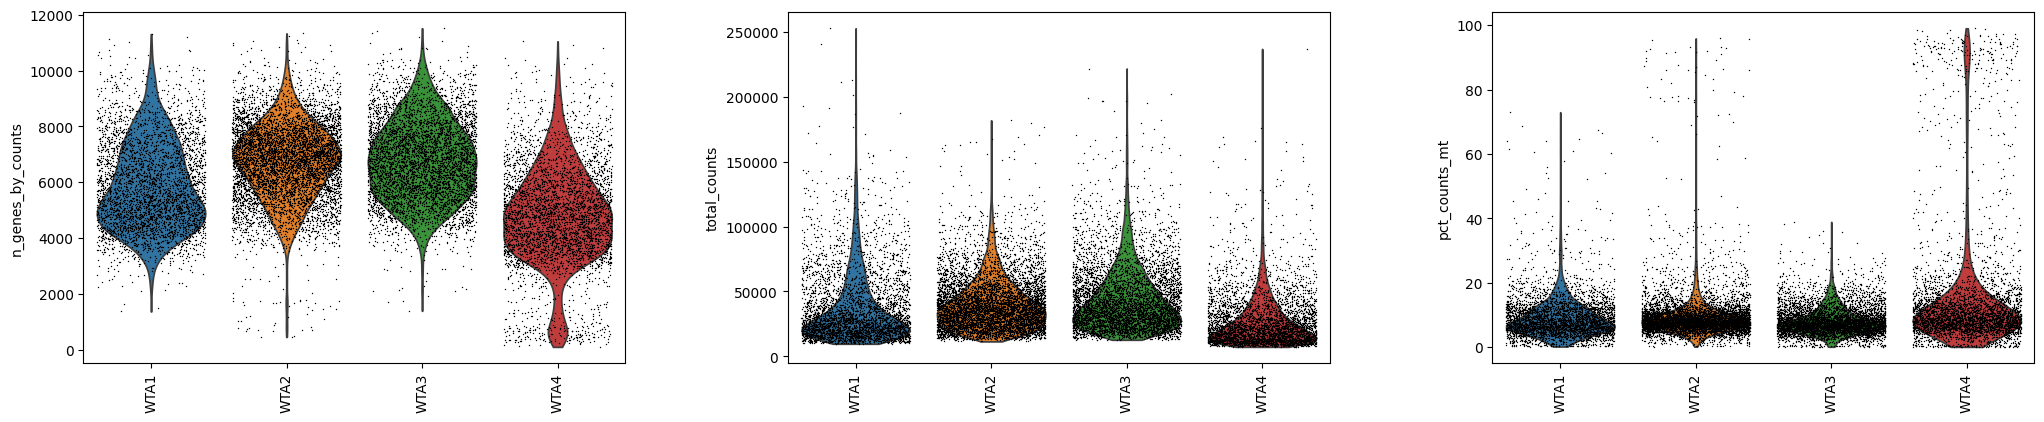

In [ ]:
sc.pl.violin(
    adata_merged, 
    keys=["n_genes_by_counts", "total_counts", "pct_counts_mt"], 
    jitter=0.4, 
    groupby="Sample",  # Group by sample
    rotation=90, 
)

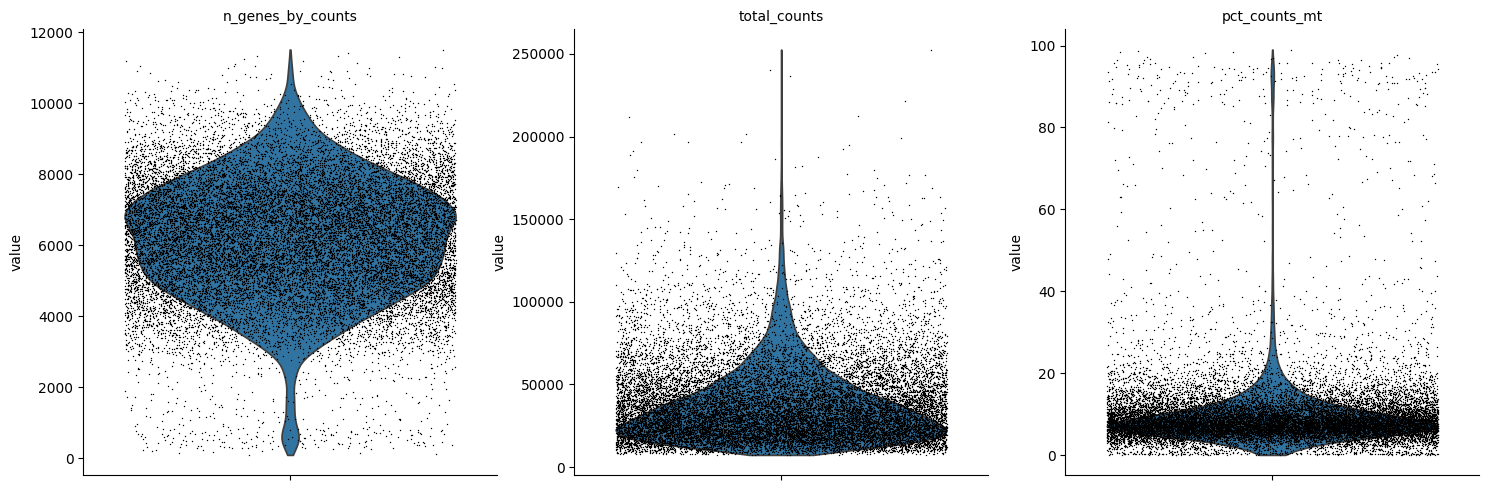

In [ ]:
sc.pl.violin(
    adata_merged,
    keys=["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    rotation=90, 
    multi_panel=True,
    jitter=0.4, 
)

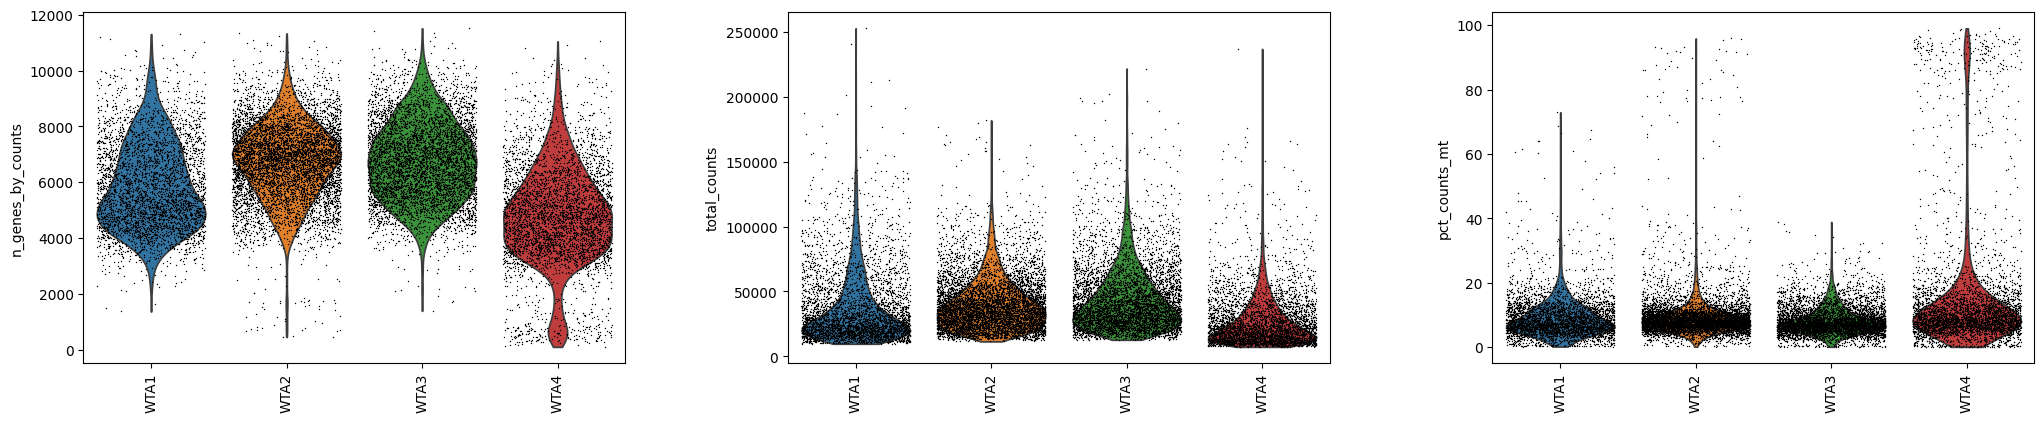

In [ ]:
sc.pl.violin(
    adata_merged, 
    keys=["n_genes_by_counts", "total_counts", "pct_counts_mt"], 
    jitter=0.4, 
    groupby="Sample",  # Group by sample
    rotation=90, 
)

In [ ]:
# Cell X
print("Filtering data based on QC metrics")

# Apply filtering conditions
adata_merged = adata_merged[
    (adata_merged.obs["n_genes_by_counts"] > 2500) &
    (adata_merged.obs["total_counts"] > 500) &
    (adata_merged.obs["pct_counts_mt"] < 25) &
    (adata_merged.obs["total_counts"] < 100000) &
    (adata_merged.obs["n_genes_by_counts"] < 10000)
]

# Confirm filtering
print(f"Remaining cells after filtering: {adata_merged.n_obs}")


Filtering data based on QC metrics
Remaining cells after filtering: 19638


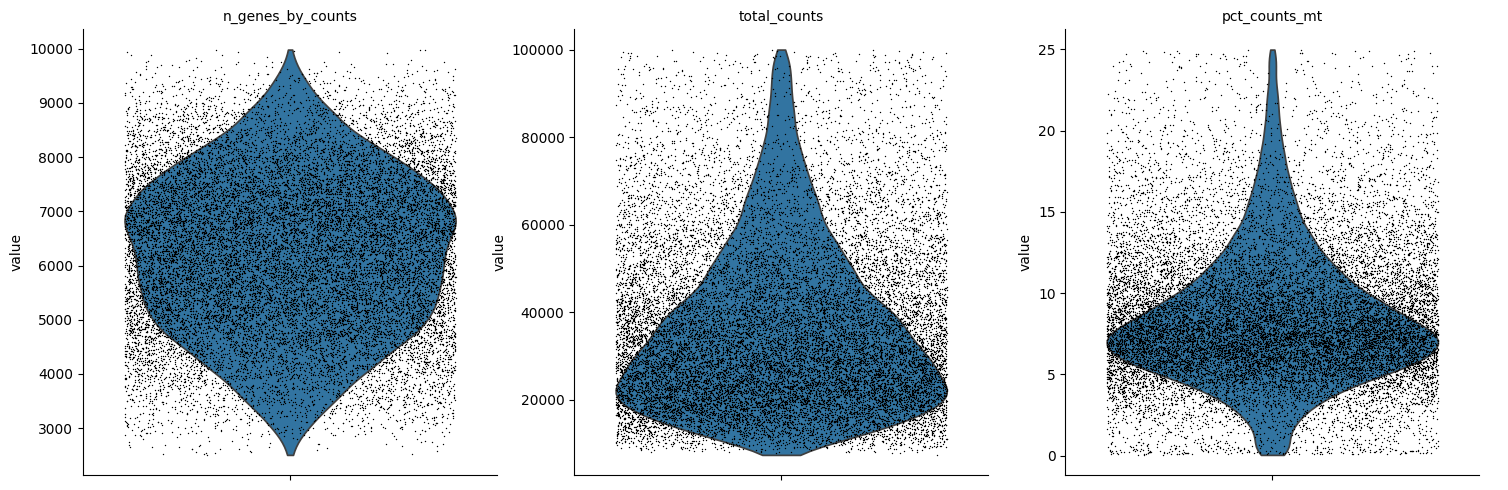

In [ ]:
sc.pl.violin(
    adata_merged,
    keys=["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    rotation=90, 
    multi_panel=True,
    jitter=0.4, 
)

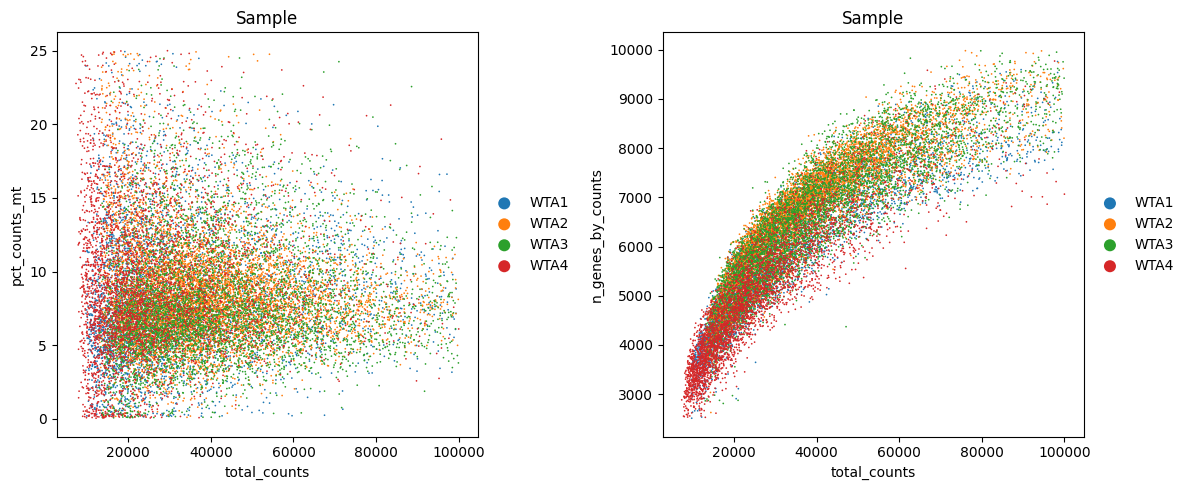

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.scatter(
    adata_merged, x="total_counts", y="pct_counts_mt", color="Sample", ax=axes[0], show=False
)
sc.pl.scatter(
    adata_merged, x="total_counts", y="n_genes_by_counts", color="Sample", ax=axes[1], show=False
)
plt.tight_layout()
plt.show()


In [ ]:
df = adata_merged.to_df()

NameError: name 'adata_merged' is not defined

Running standard workflow for visualization and clustering with intermediate checks
           Sample  n_genes_by_counts  total_counts  total_counts_mt  \
Cell_Index                                                            
4291295      WTA1               8560         95341            15816   
4887175      WTA1               8935         96455             9400   
7684639      WTA1               8295         89025            12798   
9168388      WTA1               8527         94968            12128   
1354063      WTA1               8105         79236            12284   

            pct_counts_mt leiden Cluster  
Cell_Index                                
4291295         16.588876      6       6  
4887175          9.745477      6       6  
7684639         14.375737      6       6  
9168388         12.770617      6       6  
1354063         15.503054      6       6  
Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610010F05Rik',
       '0610010K14Rik', '0610012D04Rik', '

/Users/conorisco/Library/CloudStorage/OneDrive-TrinityCollegeDublin/TCD Omics/Runs/RCSI/data and analysis/Python_pipeline/Leo_Phelan_Project/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


PCA completed.
UMAP embedding (first 5 cells):
[[-4.867366  18.798468 ]
 [-4.821589  19.736814 ]
 [-4.909626  18.783047 ]
 [-4.9045043 18.92276  ]
 [-4.5483446 18.571407 ]]


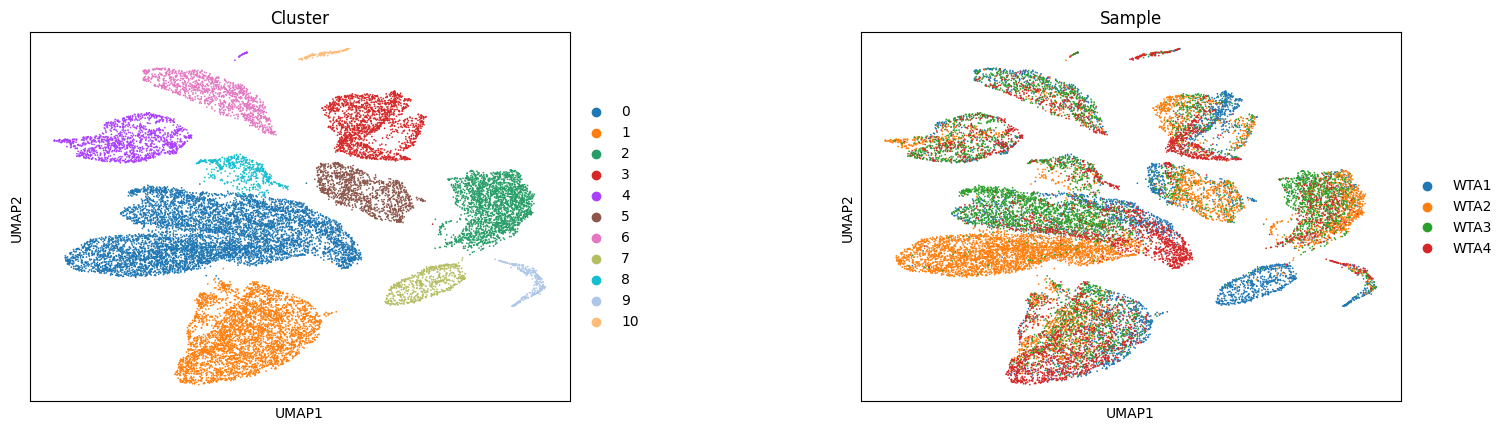

In [ ]:
# Cell X
print("Running standard workflow for visualization and clustering with intermediate checks")

# Ensure the integrated data is being used for further analysis
adata_merged.raw = adata_merged # Preserve raw data
sc.pp.scale(adata_merged)  # Scale the data


print(adata_merged.obs.head())
print(adata_merged.var_names[:10]) 
# Run PCA
sc.tl.pca(adata_merged.T, svd_solver='arpack', n_comps=30)
print("PCA completed.")

sc.pp.neighbors(adata_merged, n_pcs=30, use_rep="X_pca")  # Build neighborhood graph using PCA
sc.tl.umap(adata_merged)
print("UMAP embedding (first 5 cells):")
print(adata_merged.obsm['X_umap'][:5])
sc.tl.leiden(adata_merged, resolution=0.1)
adata_merged.obs['Cluster'] = adata_merged.obs['leiden']
# Visualize UMAP with clusters
sc.pl.umap(adata_merged, color=['Cluster', 'Sample'], wspace=0.4)


In [ ]:
# Cell X
print("Visualizing PCA")

# PCA Heatmap (Top 15 Components)
sc.pl.pca_variance_ratio(adata_merged, log=True, n_pcs=30)  # Variance ratio for top 15 components

# DimPlot equivalent: Visualize PCA
sc.pl.pca(adata_merged, color="Sample")  # Color points by Sample


Visualizing PCA


TypeError: pca_variance_ratio() got an unexpected keyword argument 'logn'